In [1]:
import Pkg; Pkg.activate(@__DIR__)
using Pkg; Pkg.instantiate()
using DifferentialEquations, LinearAlgebra, Statistics, Random, HypothesisTests
using StatsPlots, Plots, Distributions, KernelDensity, StatsBase, CSV, DataFrames
using LaTeXStrings, Measures, FileIO, JLD2

  Activating project at `~/Documents/Bachelor Thesis Stuff/bachelorsthesis`


### Reaction Kinetics

In [2]:
# === Load Experimental Data ===
df = CSV.read("datasetsMA/nitrogenlim.csv", DataFrame)
dfs = hcat(df.Xa, df.Xi, df.N, df.S, df.FG, df.MA)
u0 = dfs[1, :]
t_exp = df.time
T = 40
tspan = (0.0, T)
dt = 0.01
tsteps = collect(0.0:dt:T)
Nt = length(tsteps)

# === Define ODE Model ===
function f!(du, u, p, t)
    # Unpack state and parameters
    μmax, KFG, KN, YXa_S, YXi_S, YXa_N, YP_S, ϕ, χacc, μ2max, qsplit_max, Ksuc, qpmax, KIP, KIN, KPFG, KFG2, σxa, σxi, σn, σs, σfg, σp = p
    Xact, Xinact, N, Suc, FruGlu, P = u

    # Ensure non-negative values
    ϵ = 1e-8  # Small positive value to avoid division by zero
    Xact_safe = max(Xact, ϵ)
    Xtot_safe = max(Xact + Xinact, ϵ)
    FruGlu_safe = max(FruGlu, ϵ)
    Suc_safe = max(Suc, ϵ)

    # Algebraic equations
    Xtot = Xact + Xinact
    N_int = 0.08 * N
    ratio = Xinact / Xact_safe
    expo_term = (ratio - ϕ) / χacc

    μ = μmax * FruGlu_safe / (FruGlu_safe + KFG + ϵ) * (N / (N+ KN + ϵ))
    μ2 = μ2max * FruGlu_safe / (FruGlu_safe + KFG2 + ϵ) * (1 - exp(expo_term)) * KIN / (KIN + N + ϵ)
    qsplit = qsplit_max * Suc_safe / (Suc_safe + Ksuc + ϵ)
    qp = qpmax * FruGlu_safe / (FruGlu_safe + KPFG + ϵ) *
         (KIP / (KIP + N_int / Xtot_safe + ϵ)) * KIN / (KIN + N + ϵ)

    du[1] = μ * Xact
    du[2] = μ2 * Xact
    du[3] = - (μ / YXa_N) * Xact
    du[4] = - qsplit * Xact
    du[5] = (qsplit - μ / YXa_S - μ2 / YXi_S - qp / YP_S) * Xact
    du[6] = qp * Xact
end

# === Define Noise Function ===
function noise!(du, u, p, t)
    Xact, Xinact, N, Suc, FruGlu, P = u
    μmax, KFG, KN, YXa_S, YXi_S, YXa_N, YP_S, ϕ, χacc, μ2max, qsplit_max, Ksuc, qpmax, KIP, KIN, KPFG, KFG2, σxa, σxi, σn, σs, σfg, σp = p
    du[1] = σxa * FruGlu / (FruGlu + (KFG)) * Xact
    du[2] = σxi * FruGlu / (FruGlu + (KFG2)) * Xact
    du[3] = σn * N / (N + KN) * Xact
    du[4] = σs * Suc / (Suc + Ksuc) * Xact
    du[5] = σfg * FruGlu / (FruGlu + (Ksuc + KFG + KFG2 + KPFG)) * Xact
    du[6] = σp * FruGlu / (FruGlu + (KPFG)) * Xact
end

# === Parameters ===
params = [
    0.125,  # 1. μmax
    0.147,  # 2. KFG
    3.8e-5,  # 3. KN
    0.531,  # 4. YXa_S
    0.799,  # 5. YXi_S
    9.428,  # 6. YXa_N
    0.508,  # 7. YP_S
    1.56,  # 7. ϕ
    0.3,  # 8. χacc
    0.125,  # 9. μ2max
    1.985,  # 10. qsplit_max
    0.00321,  # 11. Ksuc
    0.095,  # 12. qpmax
    1.47e-1,  # 13. KIP
    1.47e-2,  # 14. KIN
    0.0175,  # 15. KPFG
    3.277,  # 16. KFG2
    5e-2,   # 17. σxa
    5e-2,   # 18. σxi
    1e-2,   # 19. σn
    5e-2,   # 20. σs
    5e-2,   # 21. σfg
    5e-2    # 22. σp
]

# === Solve the ODE ===
odeprob = ODEProblem(f!, u0, tspan, params)
odesol = solve(odeprob, Rosenbrock23(), saveat=tsteps, abstol=1e-8, reltol=1e-6)

# === Extract ODE solution ===
Xa_ode = odesol[1, :]
Xi_ode = odesol[2, :]
N_ode  = odesol[3, :]
Suc_ode = odesol[4, :]
FG_ode = odesol[5, :]
P_ode = odesol[6, :]

# === Important Information ===
println(Nt, " time steps")
println("Initial conditions: ", u0)

4001 time steps
Initial conditions: [1.85, 0.0, 0.762155059, 61.957, 12.30333333, 0.0]


### Monte Carlo Simulations

In [3]:
# # === Define the non-negative callback and the SDE Problem ===
# function project!(integrator)
#     integrator.u .= max.(integrator.u, 0.0)
# end
# proj_cb = DiscreteCallback((u,t,integrator) -> true, project!; save_positions = (false, false))

# sdeprob = SDEProblem(f!, noise!, u0, tspan, params)

# # === Simulate the scenarios ===
# M = 5000  # Number of simulations

# ensemble_prob = EnsembleProblem(sdeprob, prob_func = (prob, i, repeat) -> remake(prob, u0 = u0))
# ensemble_sol = solve(ensemble_prob, EM(), EnsembleThreads(), trajectories=M, dt=dt,
#                      saveat=tsteps, callback=proj_cb)

# # Extract results
# Xact_mat = hcat([sol[1, :] for sol in ensemble_sol]...)
# Xinact_mat = hcat([sol[2, :] for sol in ensemble_sol]...)
# N_mat = hcat([sol[3, :] for sol in ensemble_sol]...)
# Suc_mat = hcat([sol[4, :] for sol in ensemble_sol]...)
# FruGlu_mat = hcat([sol[5, :] for sol in ensemble_sol]...)
# P_mat = hcat([sol[6, :] for sol in ensemble_sol]...)

# # === Important Information ===
# println(size(ensemble_sol))
# println(size(FruGlu_mat))

In [4]:
# Load the saved ensemble solution
ensemble_sol = load("ensembledata/ensemble_sol.jld2", "ensemble_sol")

# Extract results
Xact_mat = hcat([sol[1, :] for sol in ensemble_sol]...)
Xinact_mat = hcat([sol[2, :] for sol in ensemble_sol]...)
N_mat = hcat([sol[3, :] for sol in ensemble_sol]...)
Suc_mat = hcat([sol[4, :] for sol in ensemble_sol]...)
FruGlu_mat = hcat([sol[5, :] for sol in ensemble_sol]...)
P_mat = hcat([sol[6, :] for sol in ensemble_sol]...)

# Ensemble Summary
summ = EnsembleSummary(ensemble_sol, tsteps)

EnsembleSolution Solution of length 4001 with uType:
Float64

### Longstaff-Schwartz Initializations

In [5]:
# === Laguerre basis functions up to degree 3 ===
d = 3  # Degree of the Laguerre polynomial
M = 5000  # Number of simulations

function laguerre_design_matrix(y::Vector{Float64}, d::Int)
    Φ = zeros(length(y), d + 1)
    for i in 1:length(y)
        Φ[i,1] = 1.0
        if d >= 1
            Φ[i,2] = 1 - y[i]
        end
        if d >= 2
            Φ[i,3] = 1 - 2*y[i] + 0.5*y[i]^2
        end
        if d >= 3
            Φ[i,4] = 1 - 3*y[i] + 1.5*y[i]^2 - (1/6)*y[i]^3
        end
    end
    return Φ
end

# === Reward function ===
thresh = 0.05 *  (u0[4] + u0[5]) # Threshold for stopping condition: 5% of initial substrates (Suc + FruGlu)
reward(s) = -(s-thresh)^2

# === Important Information ===
println("Threshold for stopping condition: ", thresh)

Threshold for stopping condition: 3.7130166664999997


### Longstaff-Schwartz Algorithm

In [61]:
# === Calculate the reward at all time steps ===
rewards = reward.(FruGlu_mat)

# === Filter the paths that have not reached the threshold at the last time step (in-the-money) ===
valid_paths = findall(i -> FruGlu_mat[Nt, i] ≤ thresh, 1:M)
if isempty(valid_paths)
    error("No valid paths found at the last time step.")
end
@show length(valid_paths)

# === Prepare the matrices for backward induction ===
# Only keep the valid paths for the backward induction
s_valid = FruGlu_mat[:, valid_paths] 
rewards_valid = rewards[:, valid_paths]
τ = fill(Nt, length(valid_paths))  # Stopping times for valid paths

# === The backward induction ===
for n in (Nt-1):-1:2
    itm_idx = findall(i -> s_valid[n, i] ≤ thresh, 1:length(valid_paths))
    s_itm = s_valid[:, itm_idx]  # Stores all in-the-money paths
    s_now = s_itm[n, :]  # Current state for itm paths
    s_future = s_valid[n+1, itm_idx] # Future state for itm paths
    reward_now = reward.(s_now)  # Rewards at the current time step
    # reward_future = reward.(s_future)  # Rewards at the next time step
    reward_future = collect(Float64, reward.(s_future))
    @show typeof.(reward_future)
    
    # Regression and saving the coefficients
    ϕ = laguerre_design_matrix(s_now, d)
    β = ϕ \ reward_future  # Solve the linear system to find coefficients
    E = ϕ * β  # Calculate the expected reward for the valid paths

    for (k,i) in enumerate(itm_idx)
        if E[k] ≤ reward_now[k]  # If the expected reward is less than or equal to the current reward
            τ[k] = min(n, τ[k])  # Update the stopping time for this path
            rewards_valid[n, k] = reward_now[k]  # Keep the current reward
        else
            rewards_valid[n, k] = rewards_valid[n+1, k]  # Otherwise, carry forward
        end
    end
end


### Construct Stopping Boundary

In [62]:
# === Extract stopping states from final τ values ===
stopping_states = [s_valid[τ[k], k] for k in 1:length(valid_paths)]
stopping_times = τ

boundary = Dict{Int, Float64}()

for n in 2:Nt
    idxs = findall(x -> x == n, stopping_times)
    if !isempty(idxs)
        # Example: you could take the 95th percentile of stopping states
        states_at_n = [stopping_states[k] for k in idxs]
        boundary[n] = quantile(states_at_n, 0.95)  # or median, or min
    end
end

times = collect(keys(boundary))
states = collect(values(boundary))

1262-element Vector{Float64}:
  5.881906714111196e-7
 12.506538443308914
  5.622200846608344
 28.317338281645668
  5.988740816068222e-7
  2.435860777390161
  1.5869130184451687
 15.749051944366515
 11.275417439709305
  5.739085316744875e-7
  ⋮
 12.101322460475883
  5.730964874557045
 16.790661650107232
 14.57590673222139
  3.2319234886216637
  9.14700372385176
 10.078776046334088
 21.823126851626295
  3.20152376352313

### Plotting (Optimal Stopping)

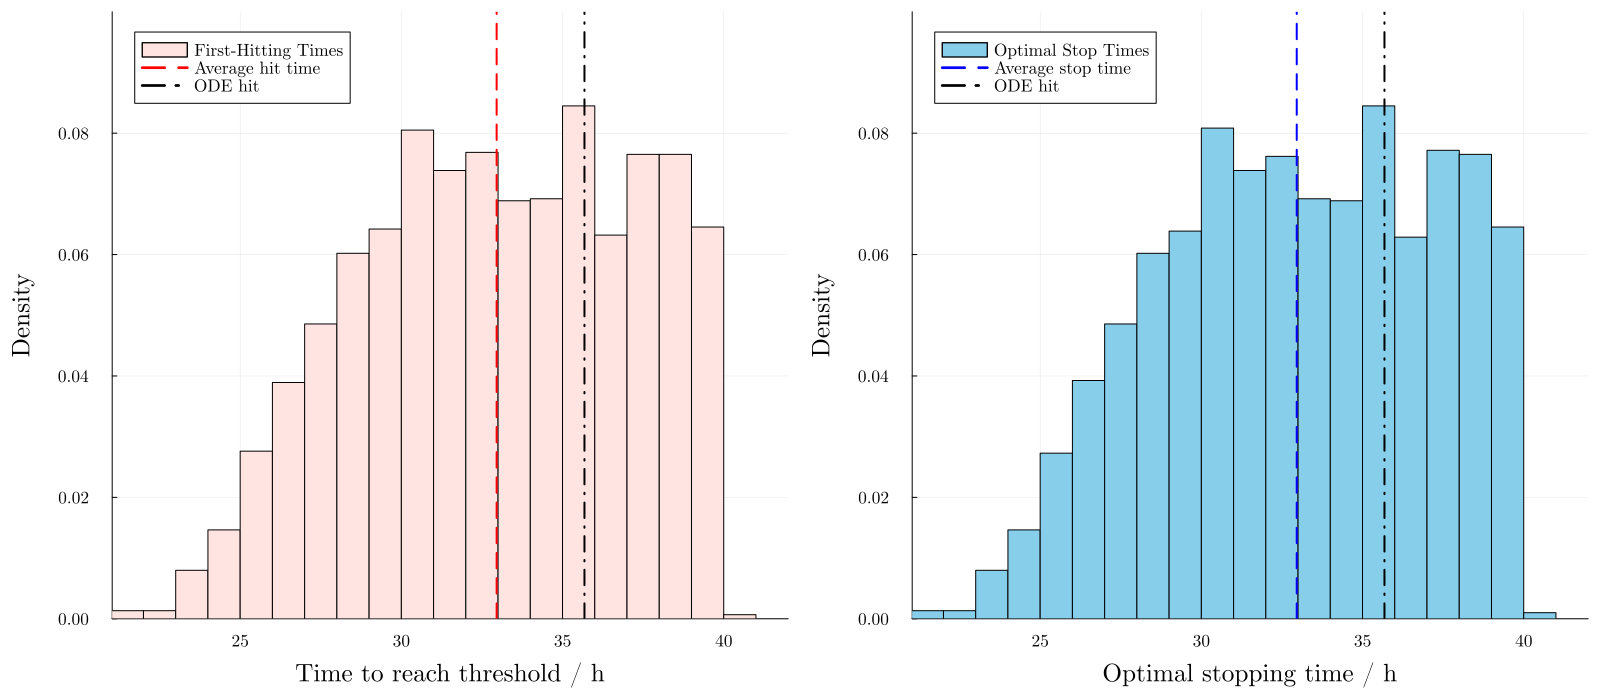

In [63]:
# === Identify when the deterministic case would have reached the threshold ===
ode_hit_index = findfirst(x -> x <= thresh, FG_ode)
ode_hit_time = tsteps[ode_hit_index]

# === Identify the actual times when the minimum threshold is reached without Longstaff-Schwartz ===
hit_indices = map(col -> findfirst(x -> x <= thresh, col), eachcol(s_valid))
hit_times = map(i -> tsteps[i], hit_indices)
hit_data = collect(hit_times)
hit_times_avg = mean(hit_data)

# === Compile the optimal stopping times ===
stop_idx   = copy(τ)          
stop_data  = tsteps[stop_idx]
stop_times_avg = mean(stop_data)

# === Prepare a common x‐range for the curves ===
xmin = minimum([minimum(hit_data), minimum(stop_data)])
xmax = 42 # maximum([maximum(hit_data), maximum(stop_data)])
xs   = range(xmin, xmax; length=200)

# === Plot histograms as densities + overlay PDF ===
p1 = histogram(hit_data;
    bins     = :auto,
    normalize= true,             # so that histogram is a density
    xlabel   = "Time to reach threshold / h",
    ylabel   = "Density",
    legendfont = 11,
    tickfont = 11,
    guidefont = 16,
    label    = "First-Hitting Times",
    color    = :mistyrose)

p2 = histogram(stop_data;
    bins     = :auto,
    normalize= true,
    xlabel   = "Optimal stopping time / h",
    ylabel   = "Density",
    legendfont = 11,
    tickfont = 11,
    guidefont = 16,
    label    = "Optimal Stop Times",
    color    = :skyblue)

# === Combine and add your vertical line ===
p_times = plot(p1, p2;
    layout = (1,2),
    size   = (1600,700),
    xlims  = (xmin, xmax),
    ylims  = (0, 0.1),
    leftmargin = 10mm,
    bottommargin = 10mm,
    legend = :topleft,
    fontfamily = "Computer Modern",
    ylabel = "Density")

vline!(p_times, [hit_times_avg];
    subplot   = 1,
    linestyle = :dash,
    linewidth = 2,
    color     = :red,
    label     = "Average hit time")

vline!(p_times, [stop_times_avg];
    subplot   = 2,
    linestyle = :dash,
    linewidth = 2,
    color     = :blue,
    label     = "Average stop time")
    
for i in 1:2
    vline!(p_times, [ode_hit_time];
        subplot   = i,
        linestyle = :dashdot,
        linewidth = 2,
        color     = :black,
        label     = "ODE hit")
end

# === Display and save the plot ===
display(p_times)
savefig(p_times, "Figures2/Two_Histograms_LSMC_MA_nofit.pdf")

# === Important Information ===
println("Average hit time: ", hit_times_avg)
println("Average stop time: ", stop_times_avg)
println("ODE hit time: ", ode_hit_time)

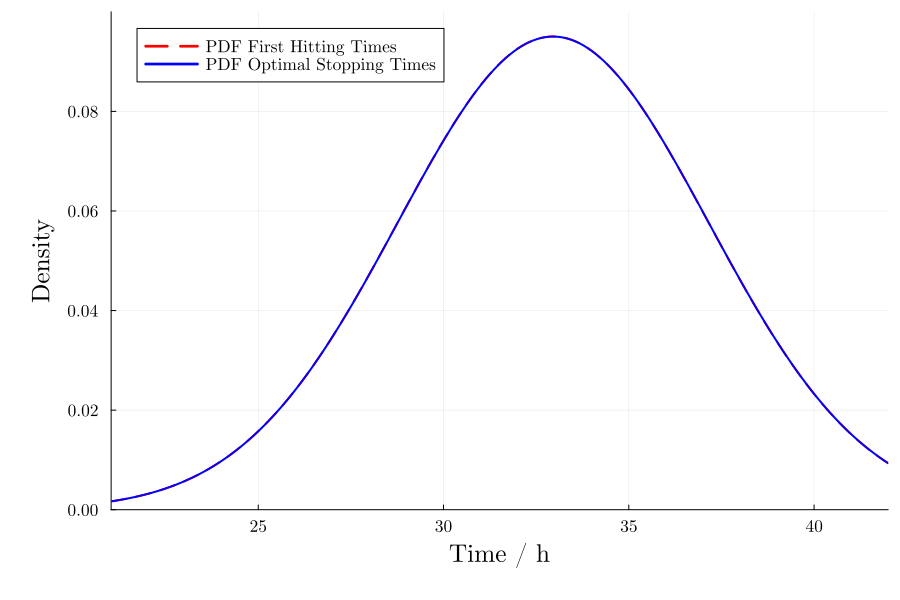

In [64]:
pdf_stop = fit(Normal, stop_data)
pdf_hit = fit(Normal, hit_data)

pdf_fit = plot(xs, pdf.(pdf_hit, xs);
    lw    = 2,
    linestyle = :dash,
    color    = :red,
    label    = "PDF First Hitting Times")

plot!(pdf_fit, xs, pdf.(pdf_stop, xs);
    lw        = 2,
    linestyle = :solid,
    color     = :blue,
    label     = "PDF Optimal Stopping Times")

plot!(fontfamily = "Computer Modern",
    xlabel = "Time / h",
    ylabel = "Density",
    legend = :topleft,
    legendfont = 11,
    tickfont = 11,
    guidefont = 16,
    xlims = (xmin, xmax),
    ylims = (0, 0.1),
    leftmargin = 10mm,
    bottommargin = 10mm,
    size = (900, 600))

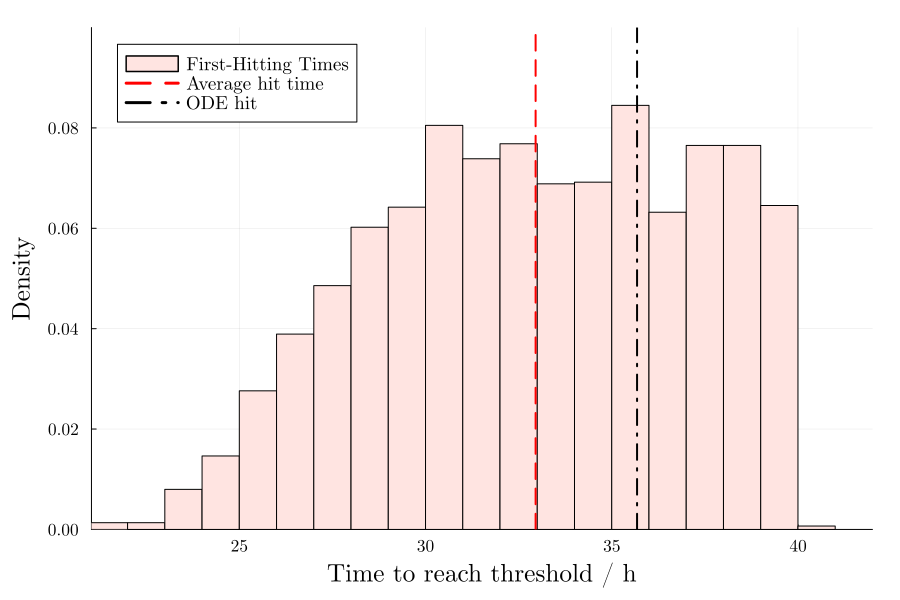

"/Users/rafif/Documents/Bachelor Thesis Stuff/bachelorsthesis/Figures2/First_Hitting_Times_LSMC_MA_nofit.pdf"

In [65]:
#   === Plot the first-hitting times histogram with PDF fit ===
hit_hist = histogram(hit_data;
    bins     = :auto,
    normalize= true,             # so that histogram is a density
    xlabel   = "Time to reach threshold / h",
    ylabel   = "Density",
    fontfamily = "Computer Modern",
    legend   = :topleft,
    legendfont = 12,
    tickfont = 11,
    guidefont = 16,
    label    = "First-Hitting Times",
    margins  = 5mm,
    color    = :mistyrose,
    size     = (900, 600),
    xlims  = (xmin, xmax),
    ylims  = (0, 0.1))

# plot!(xs, pdf.(pdf_hit, xs);
#     lw    = 2,
#     linestyle = :solid,
#     color    = :red,
#     label    = "PDF fit")

vline!([hit_times_avg];
    linestyle = :dash,
    linewidth = 2,
    color     = :red,
    label     = "Average hit time")

vline!([ode_hit_time];
        linestyle = :dashdot,
        linewidth = 2,
        color     = :black,
        label     = "ODE hit")

display(hit_hist)
savefig(hit_hist, "Figures2/First_Hitting_Times_LSMC_MA_nofit.pdf")

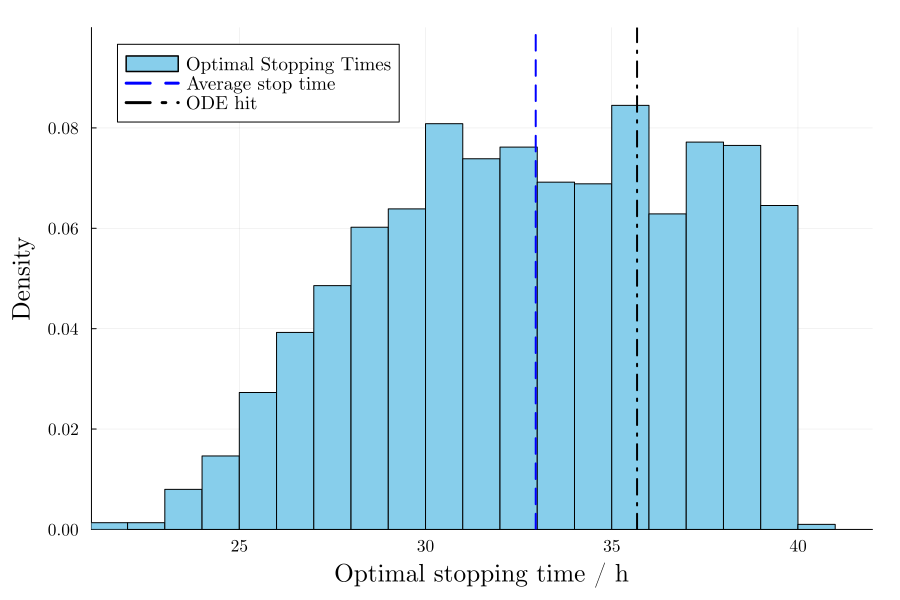

"/Users/rafif/Documents/Bachelor Thesis Stuff/bachelorsthesis/Figures2/Optimal_Stopping_Times_LSMC_MA_nofit.pdf"

In [66]:
#   === Plot the optimal stopping times histogram with PDF fit ===
stop_hist = histogram(stop_data;
    bins     = :auto,
    normalize= true,             # so that histogram is a density
    xlabel   = "Optimal stopping time / h",
    ylabel   = "Density",
    fontfamily = "Computer Modern",
    legend   = true,
    legendfont = 12,
    tickfont = 11,
    guidefont = 16,
    label    = "Optimal Stopping Times",
    color    = :skyblue,
    size     = (900, 600),
    margins  = 5mm,
    xlims  = (xmin, xmax),
    ylims  = (0, 0.1))

# plot!(xs, pdf.(pdf_stop, xs);
#     lw    = 2,
#     linestyle = :solid,
#     color    = :blue,
#     label    = "PDF fit")

vline!([stop_times_avg];
    linestyle = :dash,
    linewidth = 2,
    color     = :blue,
    label     = "Average stop time")

vline!([ode_hit_time];
        linestyle = :dashdot,
        linewidth = 2,
        color     = :black,
        label     = "ODE hit")

display(stop_hist)
savefig(stop_hist, "Figures2/Optimal_Stopping_Times_LSMC_MA_nofit.pdf")

### Plotting ODE vs SDE

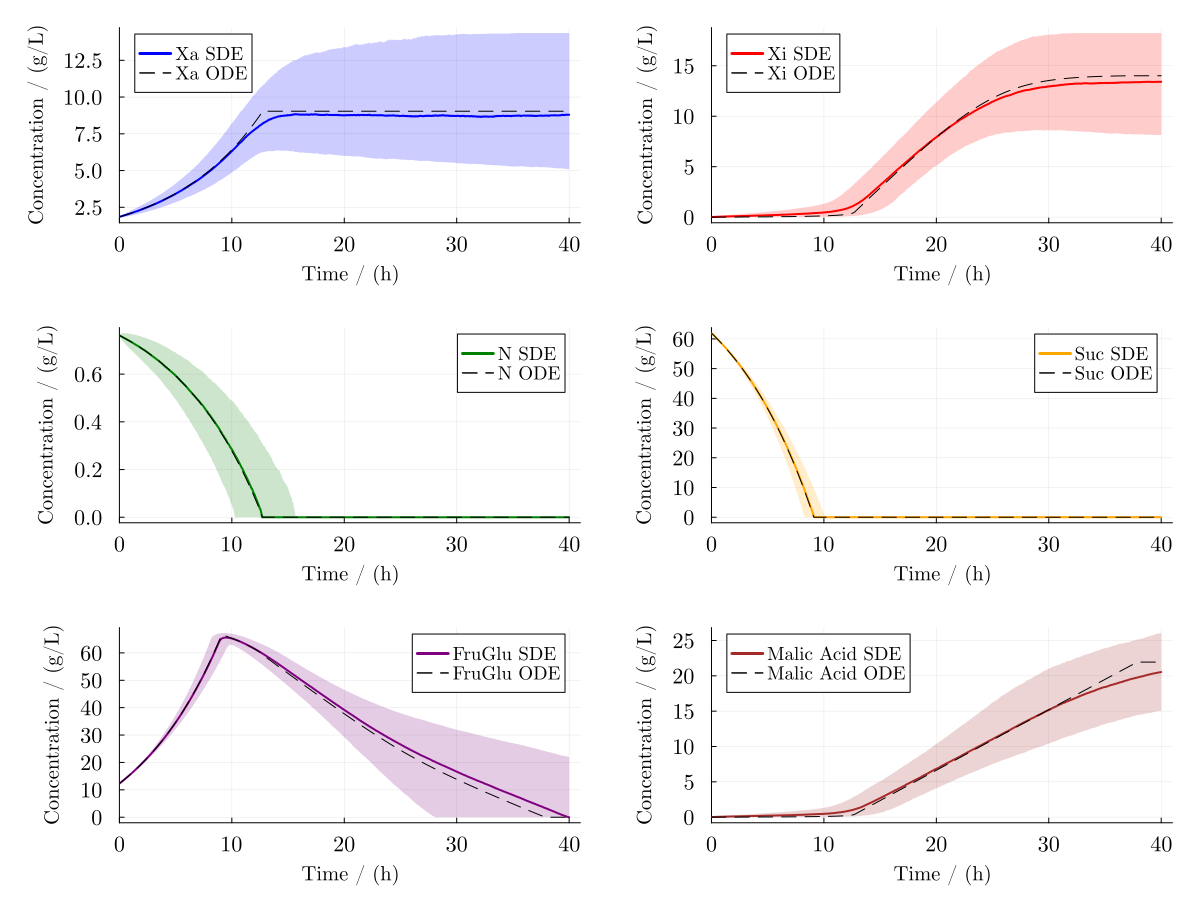

"/Users/rafif/Documents/Bachelor Thesis Stuff/bachelorsthesis/Figures2/ODE_SDE_MA_Ensemble_Summary.pdf"

In [67]:
# === Plotting ===
scene = rand(1:M)  # Choose the scene to plot (1 to M)
layout = @layout [a b; c d; e f]
p = plot(layout = layout,
         size = (1200, 900),
         leftmargin = 10mm, rightmargin = 5mm, bottommargin = 5mm,
         margins = 5mm,
         xlabel = "Time / (h)",
         ylabel = "Concentration / (g/L)",
         fontfamily = "Computer Modern",
         tickfont  = 14,
         legendfont = 12,
         guidefont = 13,
         xlims = (0, maximum(odesol.t)+1),
         legend = true)

datasets = [
    (Xact_mat[:,scene],  Xa_ode,   "Xa",  :blue, :topleft),
    (Xinact_mat[:,scene], Xi_ode,  "Xi",  :red, :topleft),
    (N_mat[:,scene],     N_ode,    "N",   :green, :topright),
    (Suc_mat[:,scene],   Suc_ode,  "Suc", :orange, :topright),
    (FruGlu_mat[:,scene],FG_ode,   "FruGlu",  :purple, :topright),
    (P_mat[:,scene],     P_ode,    "Malic Acid",   :brown, :topleft)
]

for (i, (sde_data, ode_data, name, col, leg)) in enumerate(datasets)
    # plot!(p,
    #       odesol.t, sde_data;
    #       subplot = i,
    #       label   = "$name SDE",
    #       linewidth = 2,
    #       color   = col)

    # Uncomment to plot the ensemble summary
    plot!(p,
          summ; idxs = i,
          subplot = i,
          label   = "$name SDE",
          linewidth = 2,
          color   = col,
          legend = leg)

    plot!(p,
          odesol.t, ode_data;
          subplot = i,
          label     = "$name ODE",
          linestyle = :dash,
          color    = :black)
end

display(p)
savefig(p, "Figures2/ODE_SDE_MA_Ensemble_Summary.pdf")

### Underlying Stochastic Variable (FruGlu)

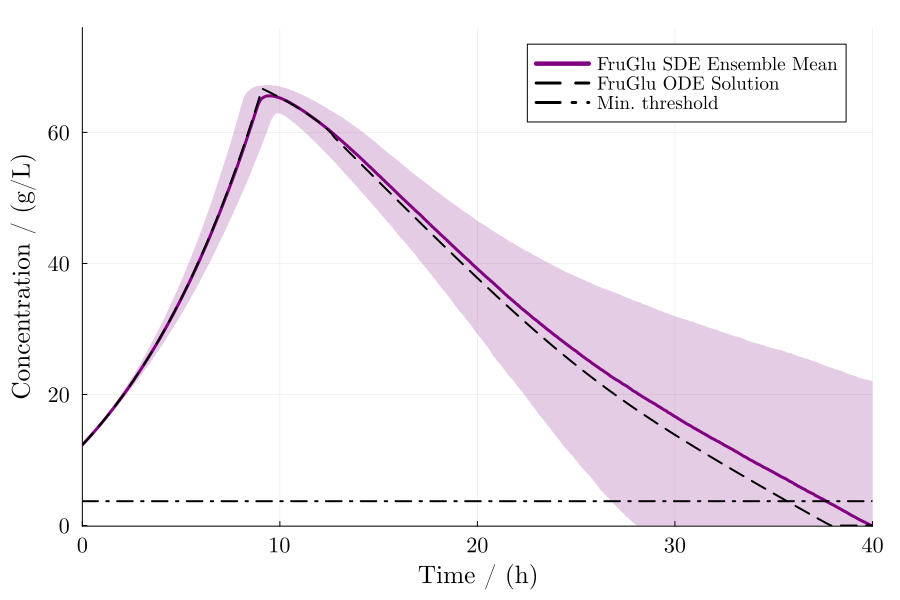

"/Users/rafif/Documents/Bachelor Thesis Stuff/bachelorsthesis/Figures2/FruGlu_Ensemble_Summary_threshold.pdf"

In [68]:
p_fruglu = plot(summ; idxs = 5, 
                xlabel = "Time / (h)",
                ylabel = "Concentration / (g/L)",
                size = (900, 600),
                margins = 5mm,
                fontfamily = "Computer Modern",
                tickfont  = 14,
                legendfont = 12,
                guidefont = 16,
                xlims = (0, maximum(odesol.t)),
                ylims = (-0.1, 76),
                label = "FruGlu SDE Ensemble Mean",
                color = :purple,
                legend = true)

plot!(p_fruglu,
      odesol.t, FG_ode;
      label = "FruGlu ODE Solution",
      lw = 2,
      color = :black,
      linestyle = :dash)

hline!(p_fruglu,
       [thresh];
       label     = "Min. threshold",
       linestyle = :dashdot,
       linewidth = 2,
       color     = :black)
       
display(p_fruglu)
savefig(p_fruglu, "Figures2/FruGlu_Ensemble_Summary_threshold.pdf")

### In-the-money FruGlu Summary and the Stopping Boundary

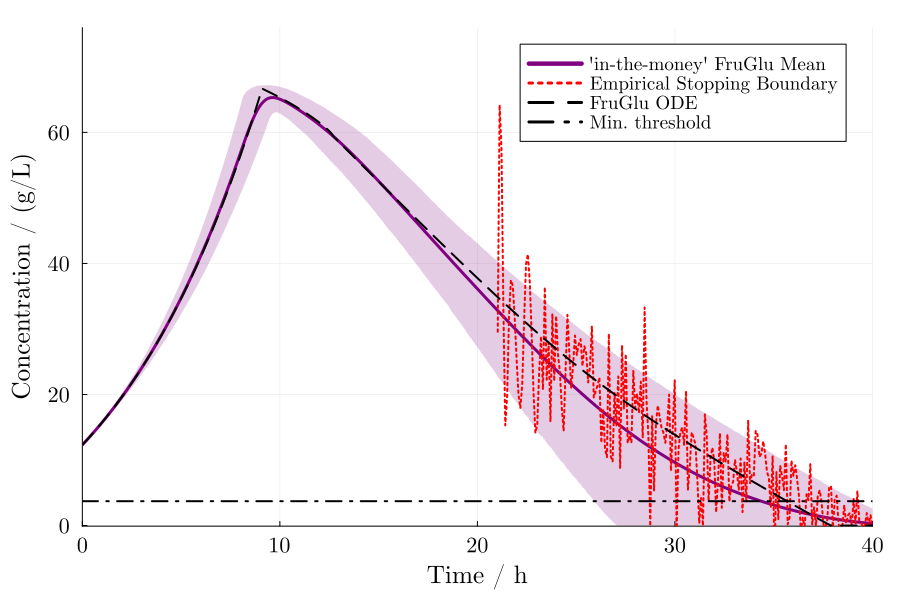

"/Users/rafif/Documents/Bachelor Thesis Stuff/bachelorsthesis/Figures2/LSMC_MA_itm_Summary_stop_bounds.pdf"

In [82]:
using Dierckx

# === Compute statistics of the filtered ensemble ===
mean_traj = mean(s_valid, dims=2)[:]
q05_traj = mapslices(x -> quantile(x, 0.05), s_valid; dims=2)[:]
q95_traj = mapslices(x -> quantile(x, 0.95), s_valid; dims=2)[:]

# Plot
p_itm = plot(
    size = (900,600),
    margins = 5mm,
    fontfamily = "Computer Modern",
    tickfont  = 14,
    legendfont = 12,
    guidefont = 16,
    xlabel = "Time / h", ylabel = "Concentration / (g/L)",
    xlims = (0, maximum(odesol.t)),
    ylims = (-0.1, 76),
)

plot!(
    tsteps, mean_traj,
    ribbon = (mean_traj .- q05_traj, q95_traj .- mean_traj),
    label = "'in-the-money' FruGlu Mean",
    lw = 3,
    linecolor = :purple,
    fillcolor = :purple,  # Color of the ribbon
    fillalpha = 0.2,         # Transparency of the ribbon
    legend = :topright
)

# Convert time steps to actual time values
time_boundary = [odesol.t[n] for n in sort(collect(keys(boundary)))]
state_boundary = [boundary[n] for n in sort(collect(keys(boundary)))]

# Fit a cubic spline
spline = Spline1D(time_boundary, state_boundary, k=3)

# Generate smooth curve
tt_smooth = range(first(time_boundary), stop=last(time_boundary), length=200)
yy_smooth = spline.(tt_smooth)

# Overlay stopping boundary on existing plot
plot!(p_itm, tt_smooth, yy_smooth;
      label = "Empirical Stopping Boundary",
      lw = 2,
      color = :red,
      linestyle = :dot)

plot!(p_itm,
      odesol.t, FG_ode;
      label = "FruGlu ODE",
      lw = 2,
      color = :black,
      linestyle = :dash)

hline!(p_itm,
       [thresh];
       label     = "Min. threshold",
       linestyle = :dashdot,
       linewidth = 2,
       color     = :black)

display(p_itm)
savefig(p_itm, "Figures2/LSMC_MA_itm_Summary_stop_bounds.pdf")

### Kolmogorov-Smirnov Test

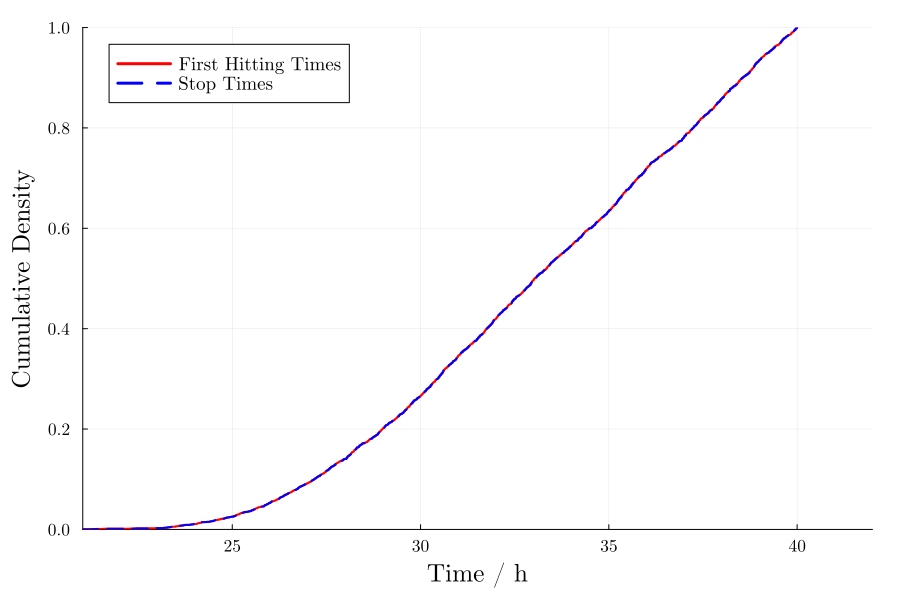

"/Users/rafif/Documents/Bachelor Thesis Stuff/bachelorsthesis/Figures2/ECDF_Hit_Stop_Times_LSMC_MA.pdf"

In [83]:
# === Plot ECDF of the stopping times and first-hitting times ===
ecdf_hit = ecdf(hit_data)
ecdf_stop = ecdf(stop_data)
p_ecdf = plot(ecdf_hit, label="First Hitting Times", color=:red, linewidth=2, size=(900, 600),
      xlims=(xmin, xmax), ylims=(0, 1),
      margins=5mm, legend=true, fontfamily="Computer Modern")
plot!(p_ecdf, ecdf_stop, label="Stop Times", color=:blue, linewidth=2,
      xlabel="Time / h", ylabel="Cumulative Density",
      legendfont = 12,
      tickfont = 11,
      guidefont = 16,
      legend=true,
      fontfamily = "Computer Modern", linestyle = :dash)
display(p_ecdf)
savefig(p_ecdf, "Figures2/ECDF_Hit_Stop_Times_LSMC_MA.pdf")

In [84]:
# === Perform the Kolmogorov-Smirnov test ===
ks_test = ApproximateTwoSampleKSTest(hit_data, stop_data)
println(ks_test)

### Kernel Density Estimation

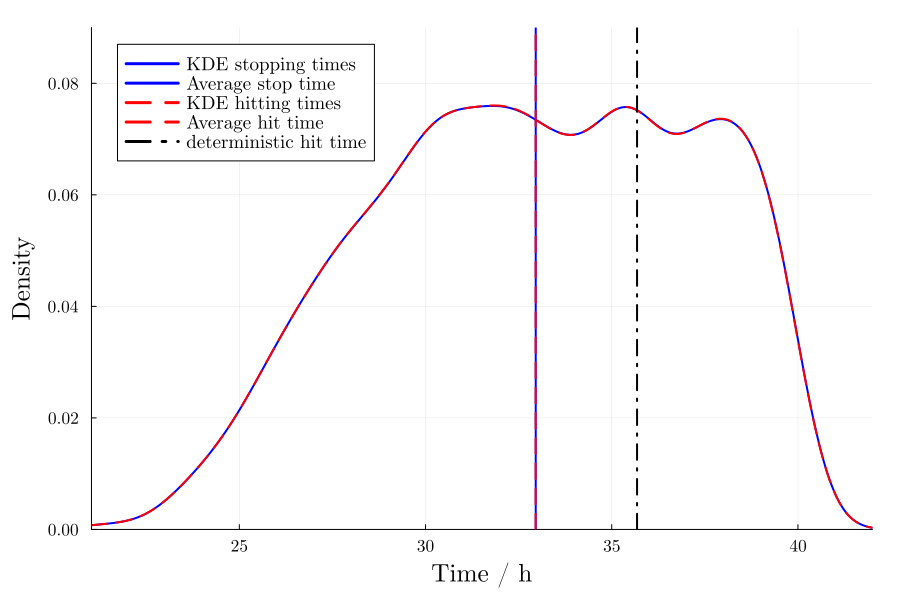

"/Users/rafif/Documents/Bachelor Thesis Stuff/bachelorsthesis/Figures2/KDE_Hit_Stop_Times_LSMC_MA.pdf"

In [85]:
kde_stop = kde(stop_data)
kde_hit = kde(hit_data)

function find_modes(x, density)
    modes = []
    for i in 2:length(density)-1
        if density[i] > density[i-1] && density[i] > density[i+1]
            push!(modes, (x[i], density[i]))
        end
    end
    return modes
end

modes = find_modes(kde_stop.x, kde_stop.density)
println("Modes of the KDE for stopping times: ", modes)

modes_hit = find_modes(kde_hit.x, kde_hit.density)
println("Modes of the KDE for hitting times: ", modes_hit)

p_kde = plot(kde_stop, label="KDE stopping times", color=:blue, linewidth=2, size=(900, 600),
            xlims=(xmin, xmax), ylims=(0, 0.09), legendfont = 12, tickfont = 11, guidefont = 16,
            margins=5mm, legend = :topright, fontfamily="Computer Modern", linestyle = :solid)
vline!(p_kde, [stop_times_avg];
    linestyle = :solid,
    linewidth = 2,
    color     = :blue,
    label     = "Average stop time")
    
plot!(p_kde, kde_hit, label="KDE hitting times", color=:red, linewidth=2,
      xlabel="Time / h", ylabel="Density",
      legend=true, linestyle = :dash,)
vline!(p_kde, [hit_times_avg];
    linestyle = :dash,
    linewidth = 2,
    color     = :red,
    label     = "Average hit time")

vline!(p_kde, [ode_hit_time];
    linestyle = :dashdot,
    linewidth = 2,
    color     = :black,
    label     = "deterministic hit time")

display(p_kde)
savefig(p_kde, "Figures2/KDE_Hit_Stop_Times_LSMC_MA.pdf")